# IA353 - Redes Neurais
# EFC3 - Questão 6 - Parte 2

# **Predição de séries temporais empregando vários tipos de modelos**
#### Parcialmente baseado em https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb
## Caso de estudo: Série temporal estacionária e não-linear

**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):** Guilherme Rosa 

### 6.1. Importações e definições

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
from pathlib import Path
import pandas as pd
import math
import csv
import sklearn
import sklearn.preprocessing
import datetime
from pandas import DataFrame
from pandas import concat
from google.colab import drive

drive.mount('/content/gdrive')
path = '/content/gdrive/My Drive/Colab Notebooks/'

# Specifi imports
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### 6.2. Carregando a base de dados e apresentando sua composição

In [ ]:
# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 

series = np.loadtxt(path + 'nlts.txt', dtype='f', delimiter=',')
print('Série original:')
print(f'Valor máximo: {np.max(series)} -- Valor mínimo: {np.min(series)}.')
print('------------------------------------------------------------------------')

series = series/15
print('Série com seus valores divididos por 15:')
print(f'Valor máximo: {np.max(series)} -- Valor mínimo: {np.min(series)}.')
print('------------------------------------------------------------------------')

series = series - np.mean(series)
print('Série modificada e com remoção da média:')
print(f'Valor máximo: {np.max(series)} -- Valor mínimo: {np.min(series)}.')
print('------------------------------------------------------------------------')

print(series[0:10])

Série original:
Valor máximo: 30.844932556152344 -- Valor mínimo: -21.777498245239258.
------------------------------------------------------------------------
Série com seus valores divididos por 15:
Valor máximo: 2.056328773498535 -- Valor mínimo: -1.4518332481384277.
------------------------------------------------------------------------
Série modificada e com remoção da média:
Valor máximo: 1.0563734769821167 -- Valor mínimo: -2.4517884254455566.
------------------------------------------------------------------------
[-0.86525667 -0.9468028  -0.99788886 -0.96390605 -0.95436054 -1.0392921
 -1.0173609  -0.8988174  -0.9328047  -0.9797272 ]


### 6.3. Exibindo o comportamento temporal da série não-linear e estacionária

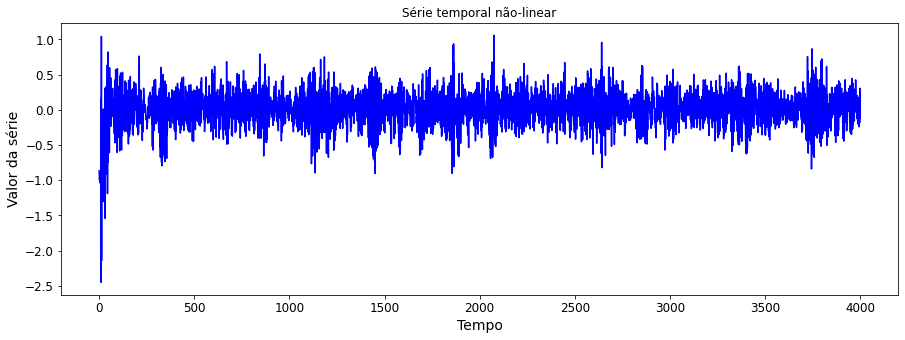

In [ ]:
plt.figure(figsize=(15, 5));
plt.plot(series, color='blue', label='open')
plt.title('Série temporal não-linear')
plt.xlabel('Tempo')
plt.ylabel('Valor da série')
plt.show()

### 6.4. Preparação da série temporal com linha de derivação de atraso, além de promover o particionamento entre conjuntos de treinamento, validação e teste

In [ ]:
# function to create train, validation, test data given stock data and sequence length
def load_data(series, seq_len):
    data_raw = np.array(series) # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len - 1): 
        data.append(data_raw[index: index + seq_len + 1])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
        
    x_train = data[:train_set_size,:-1]
    y_train = data[:train_set_size,-1]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1]
    
    x_test = data[train_set_size+valid_set_size:,:-1]
    y_test = data[train_set_size+valid_set_size:,-1]
    
    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)
    y_train = y_train.reshape(-1,1)
    x_valid = np.asarray(x_valid)
    y_valid = np.asarray(y_valid)
    y_valid = y_valid.reshape(-1,1)
    x_test = np.asarray(x_test)
    y_test = np.asarray(y_test)
    y_test = y_test.reshape(-1,1)
    
    np.savetxt('Q6P2_x_train.txt', x_train)
    np.savetxt('Q6P2_y_train.txt', y_train)
    np.savetxt('Q6P2_x_valid.txt', x_valid)
    np.savetxt('Q6P2_y_valid.txt', y_valid)
    np.savetxt('Q6P2_x_test.txt', x_test)
    np.savetxt('Q6P2_y_test.txt', y_test)

    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

# create train, test data
seq_len = 10 # Número de atrasos a serem considerados
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(series, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (3191, 10)
y_train.shape =  (3191, 1)
x_valid.shape =  (399, 10)
y_valid.shape =  (399, 1)
x_test.shape =  (399, 10)
y_test.shape =  (399, 1)


### 6.5. Visualização do comportamento da série temporal de teste

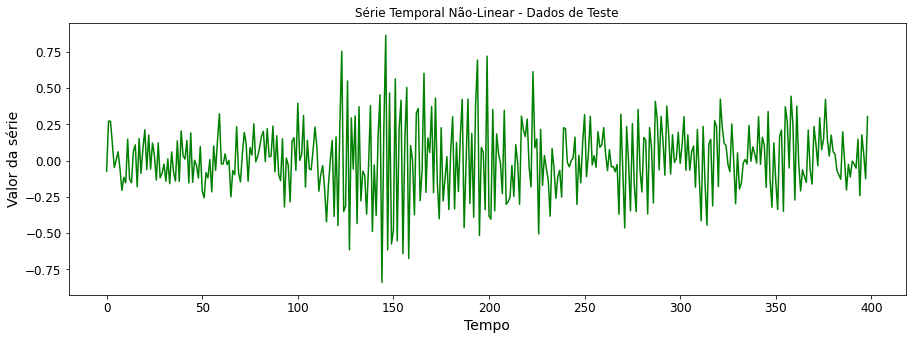

In [ ]:
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='green')
plt.title('Série Temporal Não-Linear - Dados de Teste')
plt.xlabel('Tempo')
plt.ylabel('Valor da série')
plt.show()

### 6.6. Sintetizando um preditor linear

In [ ]:
from sklearn.linear_model import LinearRegression

nr,nc = x_train.shape
B = np.ones((nr,1))
X = np.hstack((x_train,B))
lr = LinearRegression()
lr.fit(X, y_train)
w = lr.coef_
w = np.transpose(w)

print('Coeficientes do preditor linear:')
print(w)

Coeficientes do preditor linear:
[[ 0.27299142]
 [ 0.03401006]
 [-0.18766307]
 [-0.33875786]
 [ 0.05451361]
 [ 0.15593558]
 [ 0.22825877]
 [ 0.44130719]
 [ 0.05621329]
 [-0.2540271 ]
 [ 0.        ]]


#### 6.6.1. Visualização do desempenho do preditor linear

In [ ]:
from sklearn.metrics import mean_squared_error

print('EQM final de treinamento após o término do treinamento - Preditor Linear')
nr,nc = x_train.shape
B = np.ones((nr,1))
X = np.hstack((x_train,B))
y_pred = X.dot(w)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)

print('EQM final de validação após o término do treinamento - Preditor Linear')
nr,nc = x_valid.shape
B = np.ones((nr,1))
X = np.hstack((x_valid,B))
y_pred = X.dot(w)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)

print('EQM final de teste após o término do treinamento - Preditor Linear')
nr,nc = x_test.shape
B = np.ones((nr,1))
X = np.hstack((x_test,B))
y_pred = X.dot(w)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor Linear
0.043909087273997685
EQM final de validação após o término do treinamento - Preditor Linear
0.031301683631628635
EQM final de teste após o término do treinamento - Preditor Linear
0.04225981520778723


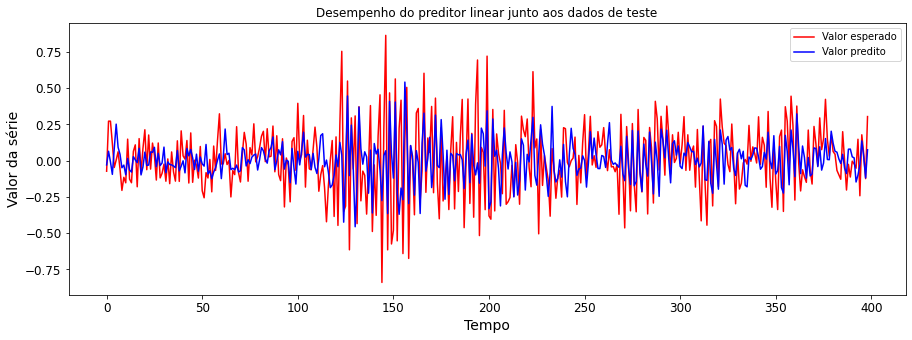

In [ ]:
y_pred = X.dot(w)

plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred, color='blue', label='Valor predito')
plt.title('Desempenho do preditor linear junto aos dados de teste')
plt.xlabel('Tempo')
plt.ylabel('Valor da série')
plt.legend(loc='best')
plt.show()

### 6.7. Sintetizando um preditor não-linear MLP

In [ ]:
EPOCHS = 100
np.random.seed(42)
tf.random.set_seed(42)

model_MLP = keras.models.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation=tf.nn.tanh),
    keras.layers.Dense(64, activation=tf.nn.tanh),
    keras.layers.Dense(1)
])

model_MLP.compile(loss="mse", optimizer="adam")

earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=EPOCHS) # Se desejar early stopping, definir patience = 10
best_val = ModelCheckpoint('model_MLP_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_MLP.fit(x_train, y_train, 
                        epochs=EPOCHS, 
                        validation_data=(x_valid, y_valid), 
                        callbacks=[earlystop, best_val], 
                        verbose=1)

Epoch 1/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0520 - val_loss: 0.0324
Epoch 2/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0477 - val_loss: 0.0402
Epoch 3/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0469 - val_loss: 0.0368
Epoch 4/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0457 - val_loss: 0.0310
Epoch 5/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0435 - val_loss: 0.0305
Epoch 6/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.0336
Epoch 7/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0437 - val_loss: 0.0311
Epoch 8/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0330
Epoch 9/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0422 - val_loss: 0.0326
Epoch 10/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0418 - val_lo

In [ ]:
model_MLP.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  1408      
_________________________________________________________________
dense_1 (Dense)              multiple                  8256      
_________________________________________________________________
dense_2 (Dense)              multiple                  65        
Total params: 9,729
Trainable params: 9,729
Non-trainable params: 0
_________________________________________________________________


#### 6.7.1. Carregando o modelo com o menor MSE para o preditor MLP

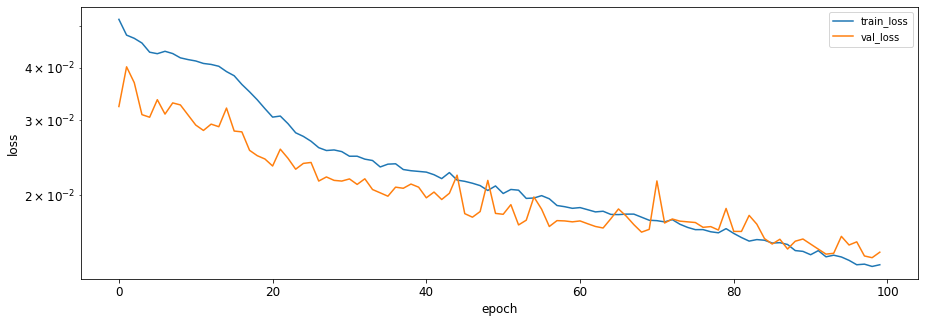

In [ ]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model_MLP.load_weights("model_MLP_{:02d}.h5".format(best_epoch))
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

#### 6.7.2. Visualização do desempenho do preditor MLP

In [ ]:
#weights = model_MLP.get_weights()
#print(weights)
print('EQM final de treinamento após o término do treinamento - Preditor MLP')
y_pred = model_MLP.predict(x_train)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)

print('EQM final de validação após o término do treinamento - Preditor MLP')
y_pred = model_MLP.predict(x_valid)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)

print('EQM final de teste após o término do treinamento - Preditor MLP')
y_pred = model_MLP.predict(x_test)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor MLP
0.012596776
EQM final de validação após o término do treinamento - Preditor MLP
0.01423327
EQM final de teste após o término do treinamento - Preditor MLP
0.0187282


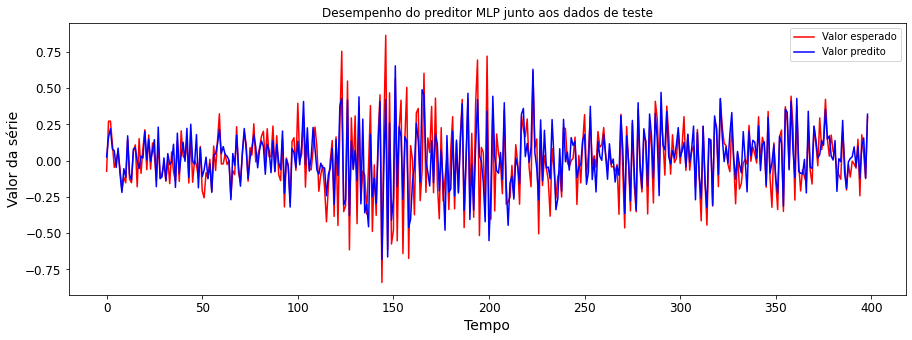

In [ ]:
y_pred = model_MLP.predict(x_test)

plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred, color='blue', label='Valor predito')
plt.title('Desempenho do preditor MLP junto aos dados de teste')
plt.xlabel('Tempo')
plt.ylabel('Valor da série')
plt.legend(loc='best')
plt.show()

### 6.8. Sintetizando um preditor não-linear Simple RNN

In [ ]:
x_train = np.asarray(x_train)
if len(x_train.shape) < 3:
    x_train = np.expand_dims(x_train, axis=2)
y_train = np.asarray(y_train)
y_train = y_train.reshape(-1,1)

x_valid = np.asarray(x_valid)
if len(x_valid.shape) < 3:
    x_valid = np.expand_dims(x_valid, axis=2)
y_valid = np.asarray(y_valid)
y_valid = y_valid.reshape(-1,1)

x_test = np.asarray(x_test)
if len(x_test.shape) < 3:
    x_test = np.expand_dims(x_test, axis=2)
y_test = np.asarray(y_test)
y_test = y_test.reshape(-1,1)

print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
print(x_test.shape)
print(y_test.shape)

np.random.seed(42)
tf.random.set_seed(42)

model_RNN1 = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model_RNN1.compile(loss="mse", optimizer="adam")
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=EPOCHS) # Se desejar early stopping, definir patience = 10
best_val = ModelCheckpoint('model_RNN1_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_RNN1.fit(x_train,
          y_train,
          epochs=EPOCHS,
          validation_data=(x_valid, y_valid),
          callbacks=[earlystop, best_val],
          verbose=1)

(3191, 10, 1)
(3191, 1)
(399, 10, 1)
(399, 1)
(399, 10, 1)
(399, 1)
Epoch 1/100
100/100 [==============================] - 2s 16ms/step - loss: 0.0622 - val_loss: 0.0316
Epoch 2/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0455 - val_loss: 0.0315
Epoch 3/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0440 - val_loss: 0.0289
Epoch 4/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0429 - val_loss: 0.0282
Epoch 5/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0396 - val_loss: 0.0272
Epoch 6/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0385 - val_loss: 0.0271
Epoch 7/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0373 - val_loss: 0.0255
Epoch 8/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0358 - val_loss: 0.0244
Epoch 9/100
100/100 [==============================] - 1s 14ms/step - loss: 0.0344 - val_loss: 0.0243
Epoch 10/100
1

In [ ]:
model_RNN1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, None, 20)          440       
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


#### 6.8.1. Carregando o modelo com o menor MSE para o preditor não-linear Simple RNN

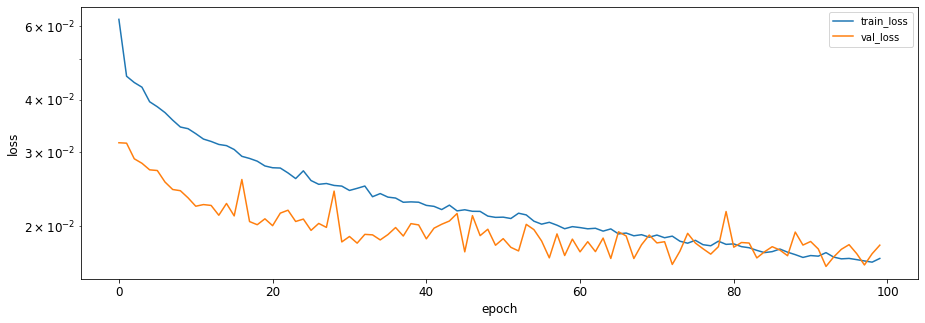

In [ ]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model_RNN1.load_weights("model_RNN1_{:02d}.h5".format(best_epoch))
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

#### 6.8.2. Visualização do desempenho do preditor não-linear Simple RNN junto aos dados de teste

In [ ]:
print('EQM final de treinamento após o término do treinamento - Preditor Simple RNN')
y_pred = model_RNN1.predict(x_train)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)

print('EQM final de validação após o término do treinamento - Preditor Simple RNN')
y_pred = model_RNN1.predict(x_valid)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)

print('EQM final de teste após o término do treinamento - Preditor Simple RNN')
y_pred = model_RNN1.predict(x_test)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor Simple RNN
0.016017549
EQM final de validação após o término do treinamento - Preditor Simple RNN
0.016005324
EQM final de teste após o término do treinamento - Preditor Simple RNN
0.020163469


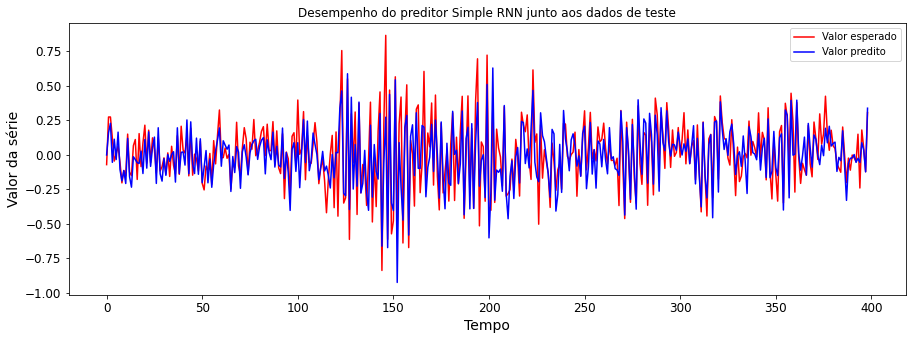

In [ ]:
y_pred = model_RNN1.predict(x_test)

plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred, color='blue', label='Valor predito')
plt.title('Desempenho do preditor Simple RNN junto aos dados de teste')
plt.xlabel('Tempo')
plt.ylabel('Valor da série')
plt.legend(loc='best')
plt.show()

### 6.9. Sintetizando um preditor não-linear com bloco LSTM GRU

In [ ]:
x_train = np.asarray(x_train)
if len(x_train.shape) < 3:
    x_train = np.expand_dims(x_train, axis=2)
y_train = np.asarray(y_train)
y_train = y_train.reshape(-1,1)

x_valid = np.asarray(x_valid)
if len(x_valid.shape) < 3:
    x_valid = np.expand_dims(x_valid, axis=2)
y_valid = np.asarray(y_valid)
y_valid = y_valid.reshape(-1,1)

x_test = np.asarray(x_test)
if len(x_test.shape) < 3:
    x_test = np.expand_dims(x_test, axis=2)
y_test = np.asarray(y_test)
y_test = y_test.reshape(-1,1)

print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
print(x_test.shape)
print(y_test.shape)

np.random.seed(42)
tf.random.set_seed(42)

model_RNN2 = keras.models.Sequential([
    keras.layers.GRU(seq_len, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(seq_len, return_sequences=True),
    keras.layers.Dense(1)
])
model_RNN2.summary()
model_RNN2.compile(loss="mse", optimizer="adam")
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=EPOCHS) # Se desejar early stopping, definir patience = 10
best_val = ModelCheckpoint('model_RNN2_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_RNN2.fit(x_train,
          y_train,
          epochs=EPOCHS,
          validation_data=(x_valid, y_valid),
          callbacks=[earlystop, best_val],
          verbose=1)

(3191, 10, 1)
(3191, 1)
(399, 10, 1)
(399, 1)
(399, 10, 1)
(399, 1)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 10)          390       
_________________________________________________________________
gru_1 (GRU)                  (None, None, 10)          660       
_________________________________________________________________
dense_4 (Dense)              (None, None, 1)           11        
Total params: 1,061
Trainable params: 1,061
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0636 - val_loss: 0.0532
Epoch 2/100
100/100 [==============================] - 0s 5ms/step - loss: 0.0632 - val_loss: 0.0536
Epoch 3/100
100/100 [==============================] - 1s 5ms/step - loss: 0.0632 - val_loss: 0.0530
Epoch 4/10

In [ ]:
model_RNN2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 10)          390       
_________________________________________________________________
gru_1 (GRU)                  (None, None, 10)          660       
_________________________________________________________________
dense_4 (Dense)              (None, None, 1)           11        
Total params: 1,061
Trainable params: 1,061
Non-trainable params: 0
_________________________________________________________________


#### 6.9.1. Carregando o modelo com o menor MSE para o preditor não-linear com bloco LSTM GRU

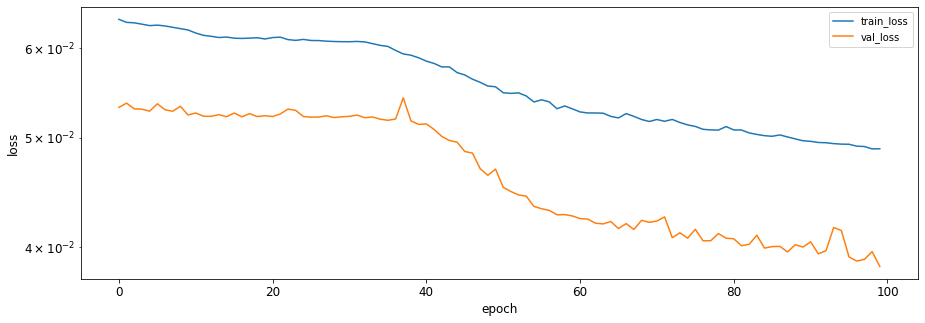

In [ ]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model_RNN2.load_weights("model_RNN2_{:02d}.h5".format(best_epoch))
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

#### 6.9.2. Visualização do desempenho do preditor não-linear com bloco LSTM GRU junto aos dados de teste

In [ ]:
print('EQM final de treinamento após o término do treinamento - Preditor LSTM GRU')
model_RNN2.evaluate(x_train,y_train)

print('EQM final de validação após o término do treinamento - Preditor LSTM GRU')
model_RNN2.evaluate(x_valid,y_valid)

print('EQM final de teste após o término do treinamento - Preditor LSTM GRU')
model_RNN2.evaluate(x_test,y_test)

EQM final de treinamento após o término do treinamento - Preditor LSTM GRU
100/100 [==============================] - 0s 3ms/step - loss: 0.0484
EQM final de validação após o término do treinamento - Preditor LSTM GRU
13/13 [==============================] - 0s 2ms/step - loss: 0.0385
EQM final de teste após o término do treinamento - Preditor LSTM GRU
13/13 [==============================] - 0s 2ms/step - loss: 0.0484


0.04836990311741829

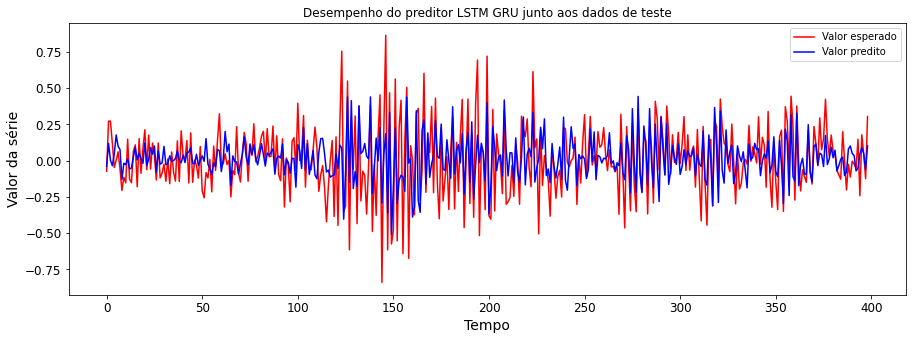

In [ ]:
y_pred = model_RNN2.predict(x_test)

plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred[:,seq_len-1], color='blue', label='Valor predito')
plt.title('Desempenho do preditor LSTM GRU junto aos dados de teste')
plt.xlabel('Tempo')
plt.ylabel('Valor da série')
plt.legend(loc='best')
plt.show()

### 6.10. Sintetizando um preditor não-linear CNN 1D
#### Parcialmente baseado em https://github.com/Azure/DeepLearningForTimeSeriesForecasting/blob/master/1_CNN_dilated.ipynb

In [ ]:
from tensorflow.keras.layers import Conv1D, Dense, Flatten
LATENT_DIM = 5
KERNEL_SIZE = 2
BATCH_SIZE = 32
model_CNN = Sequential()
model_CNN.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=1, input_shape=(seq_len, 1)))
model_CNN.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=2))
model_CNN.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=4))
model_CNN.add(Flatten())
model_CNN.add(Dense(1, activation='linear'))

model_CNN.compile(optimizer='Adam', loss='mse')
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=EPOCHS) # Se desejar early stopping, definir patience = 10
best_val = ModelCheckpoint('model_CNN_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_CNN.fit(x_train,
          y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(x_valid, y_valid),
          callbacks=[earlystop, best_val],
          verbose=1)

Epoch 1/100
100/100 [==============================] - 1s 5ms/step - loss: 0.0621 - val_loss: 0.0437
Epoch 2/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0547 - val_loss: 0.0384
Epoch 3/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0507 - val_loss: 0.0355
Epoch 4/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0484 - val_loss: 0.0340
Epoch 5/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0468 - val_loss: 0.0326
Epoch 6/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0454 - val_loss: 0.0313
Epoch 7/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0440 - val_loss: 0.0296
Epoch 8/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0431 - val_loss: 0.0288
Epoch 9/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0419 - val_loss: 0.0279
Epoch 10/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0410 - val_lo

In [ ]:
model_CNN.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 10, 5)             15        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 5)             55        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10, 5)             55        
_________________________________________________________________
flatten_1 (Flatten)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 176
Trainable params: 176
Non-trainable params: 0
_________________________________________________________________


#### 6.10.1. Carregando o modelo com o menor MSE para o preditor CNN

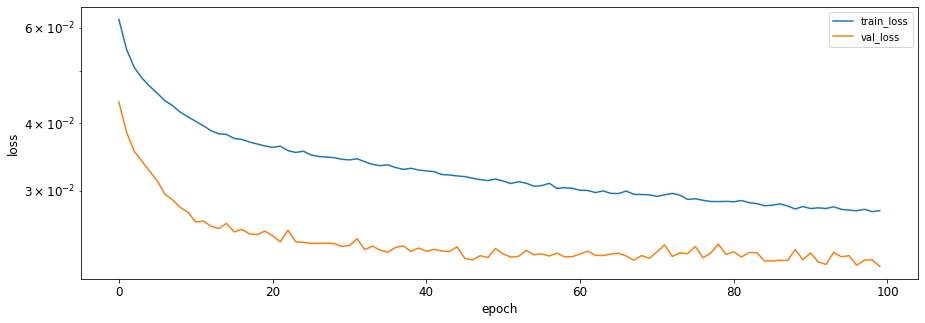

In [ ]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model_CNN.load_weights("model_CNN_{:02d}.h5".format(best_epoch))
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

#### 6.10.2. Visualização do desempenho do preditor CNN junto aos dados de teste

In [ ]:
print('EQM final de treinamento após o término do treinamento - Preditor CNN')
y_pred = model_CNN.predict(x_train)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)

print('EQM final de validação após o término do treinamento - Preditor CNN')
y_pred = model_CNN.predict(x_valid)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)

print('EQM final de teste após o término do treinamento - Preditor CNN')
y_pred = model_CNN.predict(x_test)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor CNN
0.027014364
EQM final de validação após o término do treinamento - Preditor CNN
0.021753162
EQM final de teste após o término do treinamento - Preditor CNN
0.028648205


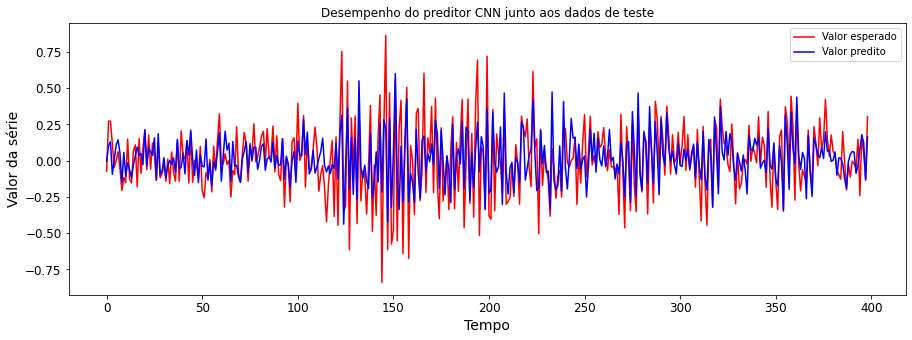

In [ ]:
y_pred = model_CNN.predict(x_test)

plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred, color='blue', label='Valor predito')
plt.title('Desempenho do preditor CNN junto aos dados de teste')
plt.xlabel('Tempo')
plt.ylabel('Valor da série')
plt.legend(loc='best')
plt.show()

# **Resolução da atividade:**

##### **6.2.1 - Forneça o notebook devidamente executado, contendo, ao final, um resumo geral do que foi trabalhado em cada seção. Forneça, por exemplo, o número de atrasos da série temporal que está sendo considerado como entrada dos preditores e como está sendo feita a regularização dos modelos, quando for o caso.**


**Seção 6.1. Importações e definições:**

- Nesta seção são feitas as importações dos módulos necessários para implementação das funcionalidades do código.
  
- Exemplos:
    
  - Numpy: tratamento de arrays N-dimensionais.
  - Pandas: download e manipulação da base de dados.
  - Scikit-learn: utilizado para o pré-processamento dos dados da série temporal e na implementação do preditor linear.
  - Tensorflow e Keras: utilizado para a implementação e treinamento dos preditores não-lineares.
  - Matplotlib: utilizado para a visualização dos dados.

**Seção 6.2. Carregando a base de dados e apresentando sua composição:**

- A série temporal do arquivo *nlts.txt* é composta por 4000 instâncias caracterizadas por um único atributo.

- É feito um pré-processamento dos dados, em que inicialmente cada valor da série é divido por um fator de 15 (este valor é próximo ao desvio padrão da série) e em seguida a média é removida.

- São apresentadas os valores máximo e mínimo antes e após cada etapa do pré-processamento.

**Seção 6.3. Exibindo o comportamento temporal da série não-linear e estacionária:**

- Nesta seção é apresentado no gráfico o comportamento temporal da série investigada.

- Como o próprio nome da seção apresenta, a série investigada tem comportamento:
  
  - Não-linear, isto é, o sistema dinâmico que gera os dados é um sistema não-linear.

  - Estacionário, ou seja, as propriedades estatística (como a média e a variância) são as mesmas ao longo do tempo.

**Seção 6.4. Preparação da série temporal com linha de derivação de atraso, além de promover o particionamento entre conjuntos de treinamento, validação e teste:**

- A função *load_data* realiza os atrasos de derivação e construção dos pares entrada-saída que compõem os dados de treinamento, validação e teste.

  - O número de atrasos de derivação é igual 10. Logo, cada padrão de entrada do *dataset* contém 10 atributos.
  - A predição estudada é um passo à frente. Logo, cada saída do *dataset* é um número real.
  - 10% dos dados são reservados para teste (399 amostras).
  - 10% dos dados são reservados para validação (399 amostras).
  - Os 80% restantes formam o conjunto de treinamento (3191 amostras).

**Seção 6.5. Visualização do comportamento da série temporal de teste:**

- Essa seção apresenta o comportamento da série temporal não-linear.

- Note que a série possui média nula.

**Seção 6.6. Sintetizando um preditor linear:**

- Um preditor linear é obtido por meio da técnica de regressão linear, tomando o Erro Quadrático Médio como função custo.

- O preditor linear é composto por 11 parâmetros, que combinam linearmente cada um dos atributos do padrão de entrada e o termo de polarização (bias).

- Após o treinamento do preditor, são apresentados os erros quadráticos médios nos conjuntos de treinamento, validação e teste, e o desempenho da série predita apenas no conjunto de teste. 

- Pode-se observar no gráfico que o preditor linear não apresentou um bom desempenho, o que já era esperado pois a série investigada é não-linear.

**Seção 6.7. Sintetizando um preditor não-linear MLP:**

- *Obs: Todos os preditores não-lineares possuem as seguintes configurações de treinamento:*
  - *Função custo: Erro Quadrático Médio*
  
  - *Algoritmo de otimização: Adam*
  
  - *Número de épocas: 100*

  - *Mini-batch com 32 amostras.*

- O preditor não-linear MLP tem a seguinte estrutura:

  - Duas camadas intermediárias *fully-connected* com, respectivamente, 128 e 64 neurônios com função de ativação tangente hiperbólica.
  
  - Camada de saída com apenas um neurônio com função de ativação linear.

- Após o treinamento do preditor, são apresentados os erros quadráticos médios nos conjuntos de treinamento, validação e teste, e o desempenho da série predita apenas no conjunto de teste.

- Nota-se que a série predita no conjunto de teste também está atrasada em uma unidade de tempo, apresenta uma variação semelhante ao da série esperada, mas com um *offset* menor. 

**Seção 6.8. Sintetizando um preditor não-linear Simple RNN:**

- *Obs: Todos os preditores não-lineares recorrentes possuem uma etapa de modificação do formato dos padrões de entrada de treinamento, validação e teste necessária para o uso desses modelos.*

  - *Formato das entradas para redes recorrentes: (Samples, TimeSteps, Features)*
    
    - *Samples: Número de sequências do dataset*. 

    - *Time Steps: Número de entradas atrasadas que compõe uma sequência.*

    - *Features: Número de atributos de cada entrada atrasada.*

  - *Por exemplo, no conjunto de treinamento, temos (3191, 10, 1).*

- O preditor não-linear simple RNN tem a seguinte estrutura:

  - Duas camadas recorrentes em série: 
    
    - A primeira camada possui 20 neurônios, cada um alimentado pelas 10 entradas da amostra atual e pelas 20 saídas da camada que são realimentadas.

    - A Segunda camada possui 20 neurônios, cada um alimentado pelas 20 saídas da camada anterior e pelas 20 saídas da própria camada que são realimentadas.

    - Os neurônios de ambas as camadas recorrentes possuem função de ativação tangente hiperbólica.
  
  - Camada de saída com apenas um neurônio com função de ativação linear.

- Após o treinamento do preditor, são apresentados os erros quadráticos médios nos conjuntos de treinamento, validação e teste, e o desempenho da série predita apenas no conjunto de teste.

**Seção 6.9. Sintetizando um preditor não-linear com bloco LSTM GRU:**

- O preditor não-linear com bloco LSTM - GRU tem a seguinte estrutura:

  - Duas camadas recorrentes com blocos LSTM GRU, cada um com sequência de saída formada por 20 elementos. 
  
  - Camada de saída com apenas um neurônio com função de ativação linear.

- Após o treinamento do preditor, são apresentados os erros quadráticos médios nos conjuntos de treinamento, validação e teste, e o desempenho da série predita apenas no conjunto de teste.

**Seção 6.10. Sintetizando um preditor não-linear CNN 1-D:**

- O preditor não-linear CNN 1-D tem a seguinte estrutura:

  - 3 camadas convolucionais, cada uma com 5 kernels de dimensão 2, função de ativação ReLU e *stride* de 1.

  - O parâmetro dilation_rate:

    - 1ª camada convolucional: os kernels recebem como entradas 2 valores adjacentes da sequência (dilation_rate = 1).

    - 2ª camada convolucional: os kernels recebem como entradas 2 valores não-adjacentes da sequência, tendo um valor da sequência entre eles. (dilation_rate = 2).

    - 3ª camada convolucional: os kernels recebem como entradas 2 valores não-adjacentes da sequência, tendo três valores da sequência entre eles. (dilation_rate = 4).
  
  - Camada de saída com apenas um neurônio com função de ativação linear.

- Após o treinamento do preditor, são apresentados os erros quadráticos médios nos conjuntos de treinamento, validação e teste, e o desempenho da série predita apenas no conjunto de teste.

##### **6.2.2 - Dadas as características da série temporal, explique o motivo pelo qual o preditor linear saiu de primeiro colocado em desempenho, na Parte 1, para último colocado nesta Parte 2.**

- Diferente da série estudada na Parte 1, a série desta atividade é preditível. Logo, é possível que preditores aprendam os padrões de geração dos valores futuros da série a partir de seus valores passados (existe correlação entre seus valores).

- A partir disso e sabendo que a série investigada é não-linear, a relação entre o valor futuro da série e seus valores passados é também não-linear, sendo, portanto, necessário algum processamento não-linear das sequências de entrada pelo preditor. Por essa razão, o preditor linear saiu de primeiro colocado em desempenho na Parte 1, para último colocado na Parte 2.



##### **6.2.3 - Escolha um dos preditores e implemente a predição de múltiplos passos à frente (several time steps ahead), explicando como funciona a sua metodologia.**

- Download e normalização da série temporal:

In [ ]:
# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 

series = np.loadtxt(path + 'nlts.txt', dtype='f', delimiter=',')
series = series/15
series = series - np.mean(series)

- Preparação da série temporal com linha de derivação de atraso, além de promover o particionamento entre conjuntos de treinamento, validação e teste:

  - Para implementar os preditores de múltiplos passos à frente é necessário que a saída também seja uma sequência de valores da série.
  - As modificações na função *load_data* que retornam as sequências desejadas de saída estão apresentadas no código abaixo juntamente com suas versões antigas correspondentes.
  - Nesse caso, o número de passos à frente a ser predita pelos preditores é igual a 10 (definido pela variável *pred_len*).
  - O número de atrasos utilizado é igual a 20.

In [ ]:
# function to create train, validation, test data given stock data and sequence length
def load_data(series, seq_len, L):
    data_raw = np.array(series) # convert to numpy array
    data = []
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len - pred_len):         # for index in range(len(data_raw) - seq_len - 1): 
        data.append(data_raw[index: index + seq_len + pred_len])    #     data.append(data_raw[index: index + seq_len + 1])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
        
    x_train = data[:train_set_size,:-pred_len]   # x_train = data[:train_set_size,:-1]
    y_train = data[:train_set_size,-pred_len:]   # y_train = data[:train_set_size, -1]

    x_valid = data[train_set_size:train_set_size+valid_set_size,:-pred_len]  # x_valid = data[train_set_size:train_set_size+valid_set_size,:-1]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-pred_len:]  # y_valid = data[train_set_size:train_set_size+valid_set_size,-1]
    
    x_test = data[train_set_size+valid_set_size:,:-pred_len]  # x_test = data[train_set_size+valid_set_size:,:-1]
    y_test = data[train_set_size+valid_set_size:,-pred_len:]  # y_test = data[train_set_size+valid_set_size:,-1]
    
    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)
    x_valid = np.asarray(x_valid)
    y_valid = np.asarray(y_valid)
    x_test = np.asarray(x_test)
    y_test = np.asarray(y_test)

    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

# create train, test data
seq_len = 20 # Número de atrasos a serem considerados
pred_len = 10
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(series, seq_len, pred_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

print('Exemplo:')
print(f'  Padrão de entrada: {x_train[0]}')
print(f'  Saída desejada: {y_train[0]}')

x_train.shape =  (3176, 20)
y_train.shape =  (3176, 10)
x_valid.shape =  (397, 20)
y_valid.shape =  (397, 10)
x_test.shape =  (397, 20)
y_test.shape =  (397, 10)
Exemplo:
  Padrão de entrada: [-0.86525667 -0.9468028  -0.99788886 -0.96390605 -0.95436054 -1.0392921
 -1.0173609  -0.8988174  -0.9328047  -0.9797272   0.15599978 -2.4517884
  1.0421048  -2.1425176  -0.10217983 -0.7046552  -0.99711853 -0.3756085
 -1.2646565  -0.9394202 ]
  Saída desejada: [-0.14221317 -1.3015989   0.0107969  -1.1471256  -0.63500863 -0.5880864
 -0.9481725  -0.7912088  -0.44204426 -1.0221306 ]


- Síntese do preditor linear de múltiplos passos à frente:

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

nr,nc = x_train.shape
B = np.ones((nr,1))
X = np.hstack((x_train,B))
lr = LinearRegression()
lr.fit(X, y_train)
w = np.transpose(lr.coef_)

print('Coeficientes do preditor linear:')
print(w)

Coeficientes do preditor linear:
[[ 6.45717900e-02 -8.07850101e-04  2.23104563e-02  7.15418159e-02
  -2.73561060e-05  4.48891715e-02  3.84575959e-02 -5.12674175e-03
   4.06481095e-02  2.73821405e-02]
 [ 6.75023338e-02  5.17226987e-02  7.10587319e-03  6.08067316e-02
   6.93733652e-02  1.56635790e-02  6.17139032e-02  1.79804629e-02
   6.62768796e-03  5.26420563e-02]
 [ 3.12377453e-02  5.87881447e-02  5.21856113e-02  1.63380956e-02
   6.06129291e-02  6.94724048e-02  1.94161641e-02  5.00844946e-02
   1.68705393e-02  8.19384296e-03]
 [ 1.01814488e-02  2.02698842e-02  5.06208472e-02  3.63293258e-02
   1.34559141e-02  4.34896766e-02  5.70796394e-02  6.37742197e-03
   3.18824102e-02  6.83363052e-03]
 [-2.15119440e-02  1.15407688e-02  1.49084804e-02  3.12592915e-02
   3.69318302e-02  2.26445402e-03  3.40411478e-02  6.11098432e-02
  -3.40648571e-03  2.43505450e-02]
 [ 3.42449094e-02 -3.37962902e-02  1.00447901e-02  2.24596060e-02
   2.74456032e-02  3.36473984e-02  1.25206718e-03  1.69230149e-02


In [ ]:
from sklearn.metrics import mean_squared_error

print('EQM final de treinamento após o término do treinamento - Preditor Linear')
nr,nc = x_train.shape
B = np.ones((nr,1))
X = np.hstack((x_train,B))
y_pred = X.dot(w)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)

print('EQM final de validação após o término do treinamento - Preditor Linear')
nr,nc = x_valid.shape
B = np.ones((nr,1))
X = np.hstack((x_valid,B))
y_pred = X.dot(w)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)

print('EQM final de teste após o término do treinamento - Preditor Linear')
nr,nc = x_test.shape
B = np.ones((nr,1))
X = np.hstack((x_test,B))
y_pred_linear = X.dot(w)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor Linear
0.048497184059810725
EQM final de validação após o término do treinamento - Preditor Linear
0.04111126808441172
EQM final de teste após o término do treinamento - Preditor Linear
0.0710587772088337


- Síntese do preditor não-linear CNN1D de múltiplos passos à frente:
  - Modificação necessária na arquitetura do preditor: a camada densa de saída precisa ser composta por 10 neurônios com funções de ativação linear.

In [ ]:
x_train = np.asarray(x_train)
if len(x_train.shape) < 3:
    x_train = np.expand_dims(x_train, axis=2)
y_train = np.asarray(y_train)

x_valid = np.asarray(x_valid)
if len(x_valid.shape) < 3:
    x_valid = np.expand_dims(x_valid, axis=2)
y_valid = np.asarray(y_valid)

x_test = np.asarray(x_test)
if len(x_test.shape) < 3:
    x_test = np.expand_dims(x_test, axis=2)
y_test = np.asarray(y_test)

print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
print(x_test.shape)
print(y_test.shape)

(3176, 20, 1)
(3176, 10)
(397, 20, 1)
(397, 10)
(397, 20, 1)
(397, 10)


In [ ]:
from tensorflow.keras.layers import Conv1D, Dense, Flatten
LATENT_DIM = 5
KERNEL_SIZE = 2
BATCH_SIZE = 32
EPOCHS = 100

model_CNN = Sequential()
model_CNN.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=1, input_shape=(seq_len, 1)))
model_CNN.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=2))
model_CNN.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=4))
model_CNN.add(Flatten())
model_CNN.add(Dense(10, activation='linear'))

model_CNN.compile(optimizer='Adam', loss='mse')
model_CNN.summary()

earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=EPOCHS) # Se desejar early stopping, definir patience = 10
best_val = ModelCheckpoint('model_CNN_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_CNN.fit(x_train,
          y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(x_valid, y_valid),
          callbacks=[earlystop, best_val],
          verbose=1)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 20, 5)             15        
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 20, 5)             55        
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 20, 5)             55        
_________________________________________________________________
flatten_2 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1010      
Total params: 1,135
Trainable params: 1,135
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
100/100 [==============================] - 1s 5ms/step - loss: 0.0591 - val_loss: 0.0515
Epoch 2/100
100/1

In [ ]:
print('EQM final de treinamento após o término do treinamento - Preditor CNN')
y_pred = model_CNN.predict(x_train)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)

print('EQM final de validação após o término do treinamento - Preditor CNN')
y_pred = model_CNN.predict(x_valid)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)

print('EQM final de teste após o término do treinamento - Preditor CNN')
y_pred_CNN = model_CNN.predict(x_test)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor CNN
0.034186803
EQM final de validação após o término do treinamento - Preditor CNN
0.033677645
EQM final de teste após o término do treinamento - Preditor CNN
0.09209941


- Exemplos de valores futuros preditos pelos preditores linear e CNN no conjunto de teste:

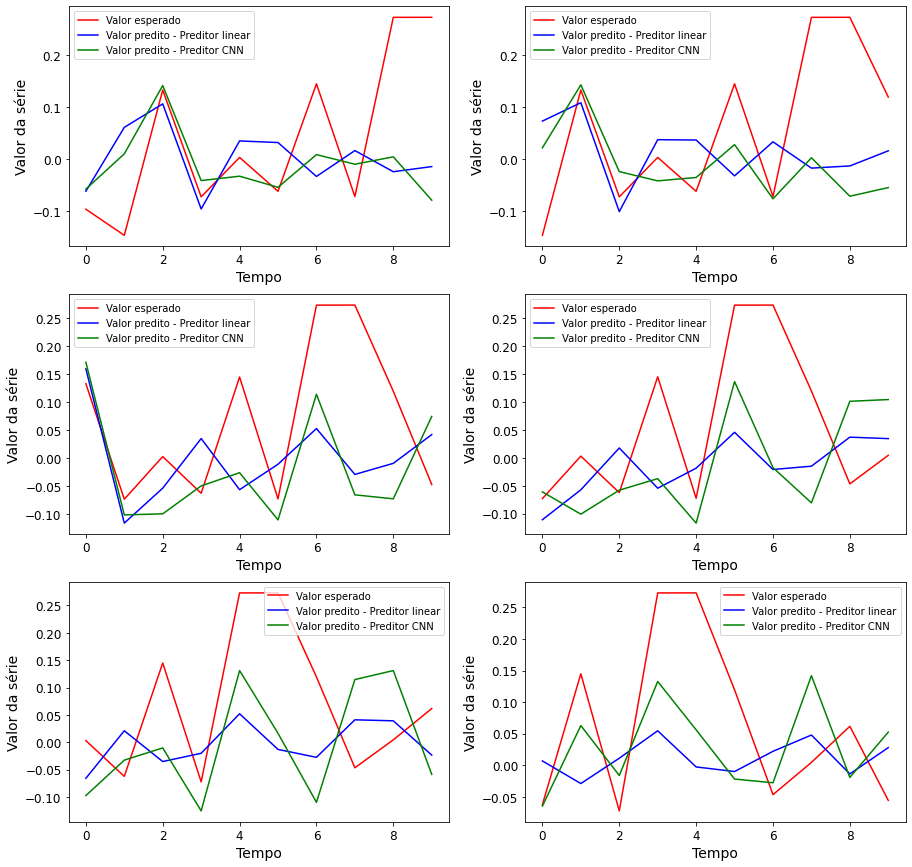

In [ ]:
fig = plt.figure(figsize=(15, 15))

ind = 0
for i in range(0, 6):
    y_pred_aux = np.reshape(y_pred_CNN[i], (10,))

    fig.add_subplot(3, 2, ind+1)
    plt.plot(y_test[i], color='red', label='Valor esperado')
    plt.plot(y_pred_linear[i], color='blue', label='Valor predito - Preditor linear')
    plt.plot(y_pred_aux, color='green', label='Valor predito - Preditor CNN')
    plt.xlabel('Tempo')
    plt.ylabel('Valor da série')
    plt.legend(loc='best')
    ind+=1

##### **6.2.4 - Sem a necessidade de implementações práticas, explique que modificações metodológicas você faria caso se constatasse que a série temporal é não-estacionária, mas com uma variação lenta de suas propriedades estatísticas ao longo do tempo.**

- Nesta situação em que a série temporal é não-estacionária o uso de um único preditor para prever toda a série se mostra insuficiente.

- Neste caso, uma maneira de implementar preditores é retreinar o modelo de tempos em tempos (o intervalo para retreinar não precisa ser pequeno, já que a variação das propriedades estatísticas é lenta) com conjuntos de treinamento e teste que incorporam novas amostras.

  - O conjunto de treinamento de um novo modelo (modelo mais atual) é formado por:
    - Um subconjunto de dados de treinamento do modelo anterior (os dados mais antigos são removidos).
    - Um subconjunto de dados de teste do modelo anterior 

  - O conjunto de teste do novo modelo é formado por novas amostras coletadas.

  